In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import numpy as np
import math
import json
from functools import partial

import matplotlib.pyplot as plt
plt.set_cmap("cividis")
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

from tqdm.auto import tqdm

/tmp/ipykernel_160192/3382477820.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf')
/home/oppenheimer/LinuxSetup/work/Transformer-JAX/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 640x480 with 0 Axes>

In [3]:
import jax
import jax.numpy as jnp
from jax import random

main_rng = random.key(42)

import flax
from flax import linen as nnx
from flax.training import train_state, checkpoints

import optax


In [4]:
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100

In [5]:
DATASET_PATH = './data'
CHECKPOINT_PATH = './checkpoints'

In [6]:
print("Device: ", jax.devices()[0])

Device:  cuda:0


In [7]:
import urllib.request
from urllib.error import HTTPError

base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial6/"

pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

os.makedirs(CHECKPOINT_PATH, exist_ok=True)

for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [12]:
def scaled_dot_product(q, k, v, mask=None):
    """
        q: jnp.Array, with dimension -1 representing dimensionality of one vector of query, -2 representing seq_len. Can have -3 for batches.
        k: jnp.Array
        v: jnp.Array
    """
    d_k = q.shape[-1]
    attn_logits = jnp.matmul(q, jnp.swapaxes(k, -2, -1)) # Can also write matmul(q, k.T) when k has only 2 dims.
    attn_logits = attn_logits / math.sqrt(d_k)
    
    if mask is not None:
        attn_logits = jnp.where(mask == 0, -9e15, attn_logits)
    attention = nnx.softmax(attn_logits, axis=-1) # Softmax is done per element in the sequence, along its dims, basically normalizing.
    values = jnp.matmul(attention, v)
    return values, attention

In [9]:
seq_len, d_k = 3, 2
main_rng, rand1 = random.split(main_rng)
qkv = random.normal(rand1, (3, seq_len, d_k))
q, k, v = qkv[0], qkv[1], qkv[2]
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 [[-0.6613315   0.70056266]
 [ 0.08239268 -1.7793142 ]
 [-0.04378588  1.0965251 ]]
K
 [[ 1.7257481   0.35568172]
 [ 1.3034704   1.2873708 ]
 [ 1.6871481  -0.5714404 ]]
V
 [[ 1.5129997   1.1050899 ]
 [ 0.27949408 -0.46224892]
 [-1.1003422  -1.1437942 ]]
Values
 [[ 0.376226   -0.14656176]
 [-0.42778552 -0.5989564 ]
 [ 0.43624765 -0.11678293]]
Attention
 [[0.27963293 0.54049295 0.17987415]
 [0.22194655 0.06706189 0.71099156]
 [0.27977088 0.58373076 0.13649833]]


In [22]:
# Helper function
# Output shape supports (batch_size, number of heads, seq length, seq length)
# if 2D: Broadcasted over batch_size and number of heads
# if 3D: Broadcasted over number of heads
# if 4D, leave as is

def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

In [33]:
class MultheadAttention(nnx.Module):
    embed_dim: int  # Output dim
    num_heads: int  # Number of parallel heads

    def setup(self):
        # Stack all weight matrices 1...h and Wq, Wk, Wv together for efficiency

        self.qkv_proj = nnx.Dense(
            features=3*self.embed_dim,
            kernel_init=nnx.initializers.xavier_uniform(),
            bias_init=nnx.initializers.zeros
        )

        self.o_proj = nnx.Dense(
            self.embed_dim,
            kernel_init=nnx.initializers.xavier_uniform(),
            bias_init=nnx.initializers.zeros
        )
        
    def __call__(self, x, mask=None):
        batch_size, seq_len, embed_dim = x.shape
        if mask is not None:
            mask = expand_mask(mask)
            
        qkv = self.qkv_proj(x)
        
        # Separate Q, K, V for linear output
        qkv = qkv.reshape(batch_size, seq_len, self.num_heads, -1)
        qkv = qkv.transpose(0, 2, 1, 3) # Batch, head, seq_len, dims
        q, k, v = jnp.array_split(qkv, 3, axis=-1)

        
        # Determine value outputs
        values, attention = scaled_dot_product(q, k , v, mask=mask)
        values = values.transpose(0, 2, 1, 3)# Batch, head, seq_len, dims
        values = values.reshape(batch_size, seq_len, embed_dim)
        o = self.o_proj(values)
        return o, attention

In [34]:
# Testing MHSA
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128)) # Batch, seq_len, embed_dim

mh_attention = MultheadAttention(embed_dim=128, num_heads=4)

# Notice the difference from torch. Flax modules must be initialized with the init function, prng_key as the first param
main_rng, init_rng = random.split(main_rng)
params = mh_attention.init(init_rng, x)['params']

# Even the class is somewhat stateless. params is the only state, and it's pulled out. You don't really use the class properties.
# Notice that with flax, we use .init() and .apply(), instead of create a class and calling it like in PyTorch.
out, attn = mh_attention.apply({'params': params}, x)
print(f"Out: {out.shape}, Attention: {attn.shape}")

Out: (3, 16, 128), Attention: (3, 4, 16, 16)


In [37]:
class EncoderBlock(nnx.Module):
    input_dim: int
    num_heads: int
    dim_feedforward: int
    dropout_prob: float
    
    def setup(self):
        # Attention
        self.self_attn = MultheadAttention(embed_dim=self.input_dim, num_heads=self.num_heads)
        
        # Two layer MLP
        self.linear = [
            nnx.Dense(self.dim_feedforward),
            nnx.Dropout(self.dropout_prob),
            nnx.relu,
            nnx.Dense(self.input_dim)
        ]
        
        self.norm1 = nnx.LayerNorm()
        self.norm2 = nnx.LayerNorm()
        self.dropout = nnx.Dropout(self.dropout_prob)
        
    def __call__(self, x, mask=None, train=True):
        attn_out, _ = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out, deterministic=not train)
        x = self.norm1(x)
        
        # MLP
        linear_out = x
        for l in self.linear:
            linear_out = l(linear_out) if not isinstance(l, nnx.Dropout) else l(linear_out, deterministic=not train)
        x = x + self.dropout(linear_out, deterministic=not train)
        x = self.norm2(x)
        
        return x

In [38]:
main_rng, x_rng = random.split(main_rng)

x = random.normal(x_rng, (3, 16, 128))

enc_block = EncoderBlock(input_dim=128, num_heads=4, dim_feedforward=512, dropout_prob=0.1)

main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = enc_block.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']

main_rng, dropout_rng = random.split(main_rng)
out = enc_block.apply({'params': params}, x, train=True, rngs={'dropout': dropout_rng})
print('Out: ', out.shape)


Out:  (3, 16, 128)


In [39]:
class TransformerEncoder(nnx.Module):
    num_layers: int
    input_dims: int
    num_heads: int
    dim_feedforward: int
    dropout_prob: float
    
    def setup(self):
        self.layers = [EncoderBlock(self.input_dims, self.num_heads, self.dim_feedforward, self.dropout_prob) for _ in range(self.num_layers)]
        
    def __call__(self, x, mask=None, train=True):
        for l in self.layers:
            x = l(x, mask=mask, train=train)
        return x
    
    def get_attention_maps(self, x, mask=None, train=True):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask)
            attention_maps.append(attn_map)
            x = l(x, mask=mask, train=train)
            
        return attention_maps
        

In [40]:
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))

encoder = TransformerEncoder(
    num_layers=5,
    input_dims=128,
    num_heads=4,
    dim_feedforward=256,
    dropout_prob=0.15
)

main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = encoder.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']


main_rng, dropout_rng = random.split(main_rng)

#intead of passing params and rngs everytime, we can bind them to the module

binded_module = encoder.bind({'params': params}, rngs={'dropout': dropout_rng})
out = binded_module(x, train=True)
print("Out: ", out.shape)
attn_maps = binded_module.get_attention_maps(x, train=True)
print(f"Attention maps: {len(attn_maps)}, {attn_maps[0].shape}")

del encoder, binded_module, params

Out:  (3, 16, 128)
Attention maps: 5, (3, 4, 16, 16)


In [57]:
class PositionalEncoding(nnx.Module):
    d_model : int         # Hidden dimensionality of the input.
    max_len : int = 5000  # Maximum length of a sequence to expect.

    def setup(self):
        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = np.zeros((self.max_len, self.d_model))
        position = np.arange(0, self.max_len, dtype=np.float32)[:,None]
        div_term = np.exp(np.arange(0, self.d_model, 2) * (-math.log(10000.0) / self.d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[None]
        self.pe = jax.device_put(pe)

    def __call__(self, x):
        x = x + self.pe[:, :x.shape[1]]
        return x

In [58]:
def cosine_warmup_schedule(base_lr: float, warmup: int, max_iters: int):
    assert warmup > 0 and max_iters > 0
    def get_lr(train_iter):
        lr_factor = 0.5 * (1 + np.cos(np.pi * train_iter / max_iters))
        if train_iter < warmup:
            lr_factor *= train_iter * 1.0 / warmup
        return lr_factor * base_lr
    return get_lr

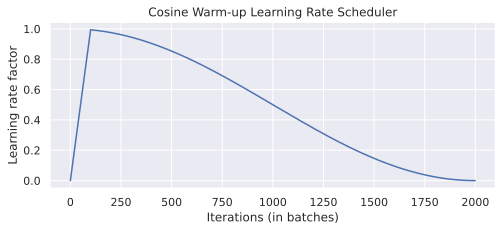

In [59]:
lr_scheduler = cosine_warmup_schedule(base_lr=1.0, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

In [60]:
class TransformerPredictor(nnx.Module):
    model_dim : int                   # Hidden dimensionality to use inside the Transformer
    num_classes : int                 # Number of classes to predict per sequence element
    num_heads : int                   # Number of heads to use in the Multi-Head Attention blocks
    num_layers : int                  # Number of encoder blocks to use
    dropout_prob : float = 0.0        # Dropout to apply inside the model
    input_dropout_prob : float = 0.0  # Dropout to apply on the input features

    def setup(self):
        # Input dim -> Model dim
        self.input_dropout = nnx.Dropout(self.input_dropout_prob)
        self.input_layer = nnx.Dense(self.model_dim)
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(self.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.num_layers,
                                              input_dims=self.model_dim,
                                              dim_feedforward=2*self.model_dim,
                                              num_heads=self.num_heads,
                                              dropout_prob=self.dropout_prob)
        # Output classifier per sequence lement
        self.output_net = [
            nnx.Dense(self.model_dim),
            nnx.LayerNorm(),
            nnx.relu,
            nnx.Dropout(self.dropout_prob),
            nnx.Dense(self.num_classes)
        ]

    def __call__(self, x, mask=None, add_positional_encoding=True, train=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
            train - If True, dropout is stochastic
        """
        x = self.input_dropout(x, deterministic=not train)
        x = self.input_layer(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask, train=train)
        for l in self.output_net:
            x = l(x) if not isinstance(l, nnx.Dropout) else l(x, deterministic=not train)
        return x

    def get_attention_maps(self, x, mask=None, add_positional_encoding=True, train=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_dropout(x, deterministic=not train)
        x = self.input_layer(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask, train=train)
        return attention_maps


In [62]:
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 64))
# Create Transformer encoder
transpre = TransformerPredictor(num_layers=5,
                                model_dim=128,
                                num_classes=10,
                                num_heads=4,
                                dropout_prob=0.15,
                                input_dropout_prob=0.05)
# Initialize parameters of transformer predictor with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transpre.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
# Apply transformer predictor with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
# Instead of passing params and rngs every time to a function call, we can bind them to the module
binded_mod = transpre.bind({'params': params}, rngs={'dropout': dropout_apply_rng})
out = binded_mod(x, train=True)
print('Out', out.shape)
attn_maps = binded_mod.get_attention_maps(x, train=True)
print('Attention maps', len(attn_maps), attn_maps[0].shape)

del transpre, binded_mod, params

Out (3, 16, 10)
Attention maps 5 (3, 4, 16, 16)


In [70]:
class TrainerModule:

    def __init__(self, model_name, exmp_batch, max_iters, lr=1e-3, warmup=100, seed=42, **model_kwargs):
        """
        Inputs:
            model_name - Name of the model. Used for saving and checkpointing
            exmp_batch - Example batch to the model for initialization
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            seed - Seed to use for model init
        """
        super().__init__()
        self.model_name = model_name
        self.max_iters = max_iters
        self.lr = lr
        self.warmup = warmup
        self.seed = seed
        # Create empty model. Note: no parameters yet
        self.model = TransformerPredictor(**model_kwargs)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, self.model_name)
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_batch)

    def batch_to_input(self, exmp_batch):
        # Map batch to input data to the model
        # To be implemented in a task specific sub-class
        raise NotImplementedError

    def get_loss_function(self):
        # Return a function that calculates the loss for a batch
        # To be implemented in a task specific sub-class
        raise NotImplementedError

    def create_functions(self):
        # Create jitted train and eval functions
        calculate_loss = self.get_loss_function()

        # Training function
        def train_step(state, rng, batch):
            loss_fn = lambda params: calculate_loss(params, rng, batch, train=True)
            ret, grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            loss, acc, rng = ret[0], *ret[1]
            state = state.apply_gradients(grads=grads)
            return state, rng, loss, acc
        self.train_step = jax.jit(train_step)

        # Evaluation function
        def eval_step(state, rng, batch):
            _, (acc, rng) = calculate_loss(state.params, rng, batch, train=False)
            return acc, rng
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_batch):
        # Initialize model
        self.rng = jax.random.PRNGKey(self.seed)
        self.rng, init_rng, dropout_init_rng = jax.random.split(self.rng, 3)
        exmp_input = self.batch_to_input(exmp_batch)
        params = self.model.init({'params': init_rng, 'dropout': dropout_init_rng}, exmp_input, train=True)['params']
        # Initialize learning rate schedule and optimizer
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=self.lr,
            warmup_steps=self.warmup,
            decay_steps=self.max_iters,
            end_value=0.0
        )
        optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),  # Clip gradients at norm 1
            optax.adam(lr_schedule)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=500):
        # Train model for defined number of epochs
        best_acc = 0.0
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            if epoch_idx % 5 == 0:
                eval_acc = self.eval_model(val_loader)
                self.logger.add_scalar('val/accuracy', eval_acc, global_step=epoch_idx)
                if eval_acc >= best_acc:
                    best_acc = eval_acc
                    self.save_model(step=epoch_idx)
                self.logger.flush()

    def train_epoch(self, train_loader, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        accs, losses = [], []
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, self.rng, loss, accuracy = self.train_step(self.state, self.rng, batch)
            losses.append(loss)
            accs.append(accuracy)
        avg_loss = np.stack(jax.device_get(losses)).mean()
        avg_acc = np.stack(jax.device_get(accs)).mean()
        self.logger.add_scalar('train/loss', avg_loss, global_step=epoch)
        self.logger.add_scalar('train/accuracy', avg_acc, global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all data points of a data loader and return avg accuracy
        correct_class, count = 0, 0
        for batch in data_loader:
            acc, self.rng = self.eval_step(self.state, self.rng, batch)
            correct_class += acc * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_acc = (correct_class / count).item()
        return eval_acc

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir, target=self.state.params, step=step)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for the pretrained model
        if not pretrained:
            params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=self.state.params)
        else:
            params = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'), target=self.state.params)
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=self.state.tx)

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this Transformer
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'))

In [71]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size, np_rng):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size
        self.np_rng = np_rng

        self.data = self.np_rng.integers(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = np.flip(inp_data, axis=0)
        return inp_data, labels

In [72]:
# Combine batch elements (all numpy) by stacking
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

dataset = partial(ReverseDataset, 10, 16)
rev_train_loader = data.DataLoader(dataset(50000, np_rng=np.random.default_rng(42)),
                                   batch_size=128,
                                   shuffle=True,
                                   drop_last=True,
                                   collate_fn=numpy_collate)
rev_val_loader   = data.DataLoader(dataset(1000, np_rng=np.random.default_rng(43)),
                                   batch_size=128,
                                   collate_fn=numpy_collate)
rev_test_loader  = data.DataLoader(dataset(10000, np_rng=np.random.default_rng(44)),
                                   batch_size=128,
                                   collate_fn=numpy_collate)

In [73]:
inp_data, labels = rev_train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: [0 7 6 4 4 8 0 6 2 0 5 9 7 7 7 7]
Labels:     [7 7 7 7 9 5 0 2 6 0 8 4 4 6 7 0]


In [74]:
class ReverseTrainer(TrainerModule):

    def batch_to_input(self, batch):
        inp_data, _ = batch
        inp_data = jax.nn.one_hot(inp_data, num_classes=self.model.num_classes)
        return inp_data

    def get_loss_function(self):
        # Function for calculating loss and accuracy for a batch
        def calculate_loss(params, rng, batch, train):
            inp_data, labels = batch
            inp_data = jax.nn.one_hot(inp_data, num_classes=self.model.num_classes)
            rng, dropout_apply_rng = random.split(rng)
            logits = self.model.apply({'params': params}, inp_data, train=train, rngs={'dropout': dropout_apply_rng})
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (logits.argmax(axis=-1) == labels).mean()
            return loss, (acc, rng)
        return calculate_loss



In [75]:
def train_reverse(max_epochs=10, **model_args):
    num_train_iters = len(rev_train_loader) * max_epochs
    # Create a trainer module with specified hyperparameters
    trainer = ReverseTrainer(model_name='ReverseTask',
                             exmp_batch=next(iter(rev_train_loader)),
                             max_iters=num_train_iters,
                             **model_args)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(rev_train_loader, rev_val_loader, num_epochs=max_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    val_acc = trainer.eval_model(rev_val_loader)
    test_acc = trainer.eval_model(rev_test_loader)
    # Bind parameters to model for easier inference
    trainer.model_bd = trainer.model.bind({'params': trainer.state.params})
    return trainer, {'val_acc': val_acc, 'test_acc': test_acc}

In [76]:
reverse_trainer, reverse_result = train_reverse(model_dim=32,
                                                num_heads=1,
                                                num_classes=rev_train_loader.dataset.num_categories,
                                                num_layers=1,
                                                dropout_prob=0.0,
                                                lr=5e-4,
                                                warmup=50)

In [77]:
print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

Val accuracy:  100.00%
Test accuracy: 100.00%


In [78]:
data_input, labels = next(iter(rev_val_loader))
inp_data = jax.nn.one_hot(data_input, num_classes=reverse_trainer.model.num_classes)
attention_maps = reverse_trainer.model_bd.get_attention_maps(inp_data)

In [79]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = jax.device_get(input_data[idx])
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [jax.device_get(m[idx]) for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

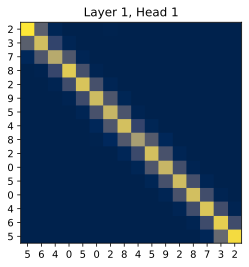

In [80]:
plot_attention_maps(data_input, attention_maps, idx=0)